### **Overview**

The goal is to analyze and explore the Data Archive using `vault_index.json`, focusing on note relationships and centrality. This will help in identifying key connections and themes.

### **1. Graph-Based Exploration**
- **Nodes & Edges:** Treat each note as a node and each link between notes as an edge, creating a graph representation of the vault.
- **Ideas for Exploration:**
  - **Centrality Ranking:** Identify the most interconnected notes.
  - **Clustering:** Group related notes based on shared tags or content similarity.
  - **Path Analysis:** Explore paths between notes to understand how ideas are connected.


### **2. Content-Based Features**
- **Word Count:** Measure the length of notes to prioritize or filter for specific note lengths.
- **Tag Density:** Assess how heavily tagged a note is, useful for filtering highly tagged or under-tagged notes.
- **Link Density:** Count the number of inlinks and outlinks to understand a note’s connectivity or centrality.



### **3. Semantic Content Mapping**
- **Embeddings/Topics:** Use embeddings or topic modeling to associate notes with broader themes or clusters.
- **Keywords:** Extract key terms from summaries or body text to improve searchability and clustering.



### **4. User-Defined Prioritization**
- **Priority Flag:** Introduce a priority system to mark important or actionable notes, e.g., using tags like #todo or #important for quick identification and filtering.


### 0: Initial Investigation

In [ ]:
import json
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Load the vault index
with open("vault_index.json", "r", encoding="utf-8") as f:
    vault = json.load(f)


In [ ]:
print(f"Loaded {len(vault)} notes from vault_index.json")
# Preview a few entries
for i, (k, v) in enumerate(vault.items()):
    print(f"{k}: {list(v.keys())}")
    if i == 1: break

Loaded 795 notes from vault_index.json
1-on-1_template: ['title', 'tags', 'aliases', 'outlinks', 'inlinks', 'summary']
ab_testing: ['title', 'tags', 'aliases', 'outlinks', 'inlinks', 'summary']
accessing_gen_ai_generated_content: ['title', 'tags', 'aliases', 'outlinks', 'inlinks', 'summary']


In [4]:
id="views"
vault[id]

{'title': 'Views',
 'tags': ['database'],
 'aliases': [],
 'outlinks': ['soft_deletion',
  'sqlite',
  'querying',
  'common_table_expression',
  'de_tools',
  'view_use_case',
  'database_schema'],
 'inlinks': ['common_table_expression'],
 'summary': 'Views are virtual tables defined by SQL [[Querying|Query]] that ==simplify complex data representation.== They can remove unnecessary columns, aggregate results, partition data, and secure sensitive...'}

In [5]:
id="common_table_expression"
vault[id]

{'title': 'Common Table Expression',
 'tags': ['database', 'querying'],
 'aliases': ['CTE'],
 'outlinks': ['de_tools', 'views', 'recursive_algorithm', 'querying'],
 'inlinks': ['views'],
 'summary': 'A Common Table Expression (CTE) is a temporary named result set that you can reference within a SELECT, INSERT, UPDATE, or DELETE statement. The CTE...'}

## Basic stats

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
# import faiss



Top 10 Tags:


In [1]:
# vault

In [19]:
first_note = list(vault.values())[0]
first_note

{'title': '1-on-1 Template',
 'tags': [],
 'aliases': [],
 'outlinks': [],
 'inlinks': ['documentation_&_meetings'],
 'summary': "Decisions [Your name] add decisions that need to be made [Other person's name] add decisions that need to be made Action items [Your name] add..."}

In [24]:
# Initialize an empty dictionary to store tag counts
tag_counts = {}

# Safeguard against invalid notes in the vault (None or non-dictionary values)
for note in vault.values():
    if isinstance(note, dict):  # Ensure note is a valid dictionary
        tags = note.get("tags", [])  # Safely get 'tags', default to empty list if none
        if isinstance(tags, list):  # Ensure tags is a list
            for tag in tags:
                if isinstance(tag, str):  # Ensure tag is a valid string
                    tag_counts[tag] = tag_counts.get(tag, 0) + 1  # Increment the count for the tag

# Sort the tags by frequency in descending order
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most common tags
print("\nTop 10 Tags:")
for tag, count in sorted_tags[:10]:
    print(f"{tag}: {count}")



Top 10 Tags:
software: 47
database: 23
data_transformation: 23
data_storage: 21
drafting: 20
evaluation: 19
statistics: 19
#question: 17
data_orchestration: 15
deep_learning: 14


In [25]:
# Find orphan notes (no inlinks or outlinks)
orphans = [
    title for title, note in vault.items()
    if not note.get("outlinks", []) and all(title not in n.get("outlinks", []) for n in vault.values())
]
print(f"\nNumber of orphan notes: {len(orphans)}")



Number of orphan notes: 55


In [ ]:

# ============================================
# 2. Construct a Directed Link Graph
# ============================================

G = nx.DiGraph()

# Add nodes and edges (ensure we fetch outlinks and other necessary attributes correctly)
for title, note in vault.items():
    G.add_node(title)  # No tags added since not directly available in the note dictionary
    outlinks = note.get("outlinks", [])  # Fetch outlinks from an external source if not in the note dictionary
    for outlink in outlinks:
        if outlink in vault:  # Only add edge if target exists
            G.add_edge(title, outlink)

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Subgraph has 6 nodes


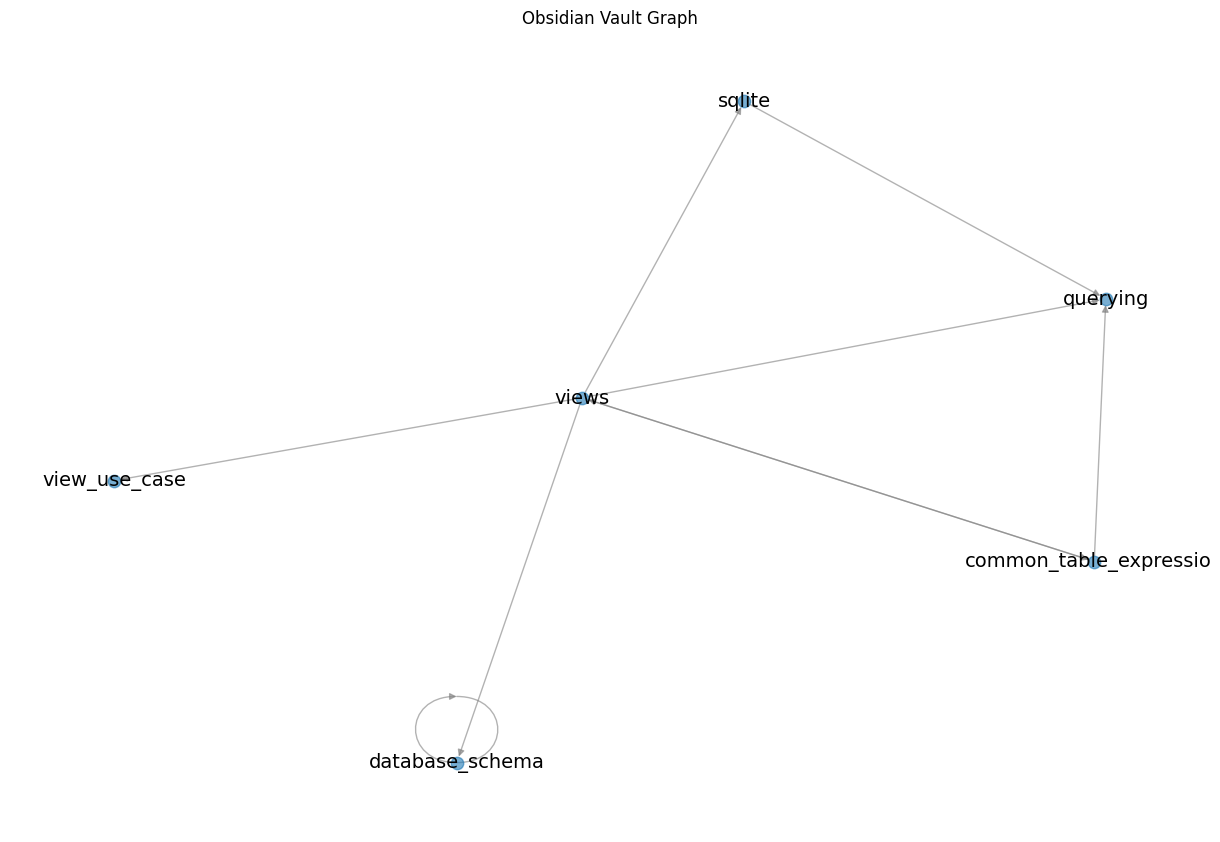

In [ ]:
def plot_graph(graph, figsize=(8, 6), label_nodes=False, font_size=14, k=0.1):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph, k=k, seed=42)  # Reduced k for shorter edges
    nx.draw(graph, pos, node_size=80, edge_color='gray', alpha=0.6)
    if label_nodes:
        nx.draw_networkx_labels(graph, pos, font_size=font_size)  # Increased font_size here
    plt.title("Obsidian Vault Graph")
    plt.axis('off')
    plt.show()


def get_subgraph(center_title, depth=1):
    if center_title not in G:
        print(f"'{center_title}' not found in graph.")
        return None
    sub = nx.ego_graph(G, center_title, radius=depth)
    print(f"Subgraph has {len(sub)} nodes")
    return sub

# Example: a 1-hop neighborhood
subG = get_subgraph("views", depth=1)
plot_graph(subG, label_nodes=True, font_size=14, k=2)  # Font size set to 14 and reduced edge length with k=0.1


In [ ]:


# ============================================
# 5. Prepare Prompt for Top-N Notes
# ============================================

def build_prompt(note_titles, vault):
    prompt = ""
    for t in note_titles:
        note = vault.get(t, {})
        prompt += f"# {t}\n"
        # Fetch tags and content from external sources or use default if not available in note dict
        tags = note.get("note_tags", [])  # Replace with actual tag source if different
        prompt += f"Tags: {', '.join(tags)}\n"
        prompt += note.get("content", "")[:500] + "\n\n"  # Fetch content or summarize
    return prompt

# Example usage
example_titles = list(subG.nodes)[:3]
prompt_text = build_prompt(example_titles, vault)
print(prompt_text)

# ============================================
# 6. Rank Notes by Centrality
# ============================================

centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: -x[1])[:10]
print("\nTop 10 central notes:")
for t, score in top_nodes:
    print(f"{t}: {score:.3f}")

# ============================================
# 7. Search Notes by Concept or Similarity (NLP)
# ============================================

# Assuming you’ve built a FAISS index keyed by title
# Load the embedding index (e.g., FAISS)
# Example: Initialize FAISS index with embeddings for note titles
# faiss_index = faiss.read_index("faiss_index_file")

# Perform semantic search from a query
query_vec = model.encode("Uncertainty quantification")
D, I = faiss_index.search(np.array([query_vec]), k=5)

# Retrieve top-k relevant note titles based on similarity
top_titles = [vault[titles[i]]['title'] for i in I[0]]
print(f"Top 5 similar notes: {top_titles}")
